# Naive Risk Budgeting Strategies between the PSP and GHP

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import edhec_risk_kit as erk
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between two sets of returns
    r1 and r2 are T x N DataFrames  or returns where T is the time step index and N i the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError('r1 and r2 need to be the same shape')
        
    weights = allocator(r1, r2, **kwargs)
    
    if not weights.shape == r1.shape:
        raise ValueError('allocator returned weights that don\'t match r1')
    
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns a T x N DataFrame for PSP weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [8]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=0.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035972,0.003577,-0.069191,3.59891,-0.001251,-0.000655,1.624784,-0.000529


In [9]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [14]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.05905,0.004729,-0.23585,2.67952,-0.002459,-0.001959,5.979243,0.0


In [15]:
summaries = erk.summary_stats(pd.DataFrame(rets_7030b))

In [16]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.080393,0.109910,-0.346974,3.030839,0.048031,0.066244,0.446118,-0.158633
1,-0.003189,0.102060,0.216608,3.173143,0.046161,0.058576,-0.316613,-0.189114
2,0.080327,0.105492,-0.021024,2.372580,0.043530,0.052899,0.464205,-0.205101
3,0.086478,0.106867,-0.199502,2.327489,0.045261,0.054542,0.514254,-0.197586
4,0.081770,0.101322,-0.271586,2.953881,0.043150,0.058656,0.497189,-0.132125


In [17]:
summaries.mean()

Annualized Return          0.053584
Annualized Vol             0.107361
Skewness                  -0.004722
Kurtosis                   2.950936
Cornish-Fisher VaR (5%)    0.046018
Historic CVaR (5%)         0.058174
Sharpe Ratio               0.214528
Max Drawdown              -0.208385
dtype: float64

In [22]:
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30')
], axis=1)

,FI,Eq,70/30
mean,1.386323,1.951917,1.770764
std,0.113982,0.974482,0.601605
p_breach,NaN,0.064000,0.022000
e_short,NaN,0.133351,0.072572
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


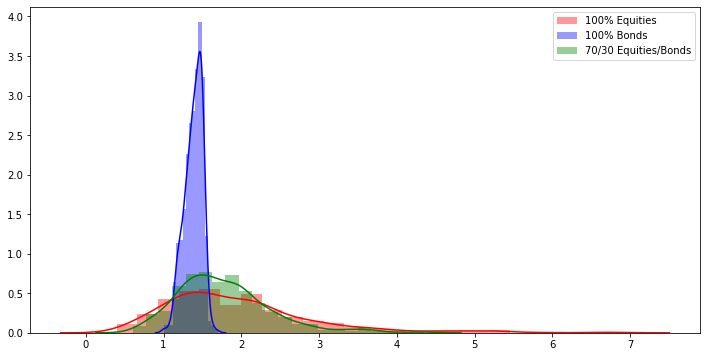

In [26]:
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color='red', label='100% Equities')
sns.distplot(erk.terminal_values(rets_bonds), color='blue', label='100% Bonds')
sns.distplot(erk.terminal_values(rets_7030b), color='green', label='70/30 Equities/Bonds')
plt.legend()

# Glide Paths for Allocation

In [27]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    """
    n_points = r1.shape[0]
    n_columns = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_columns, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [28]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=0.8, end_glide=0.2)
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30'),
    erk.terminal_stats(rets_g8020, name='Glide 80 to 20')
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.386323,1.951917,1.770764,1.656260
std,0.113982,0.974482,0.601605,0.413193
p_breach,NaN,0.064000,0.022000,0.004000
e_short,NaN,0.133351,0.072572,0.036356
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


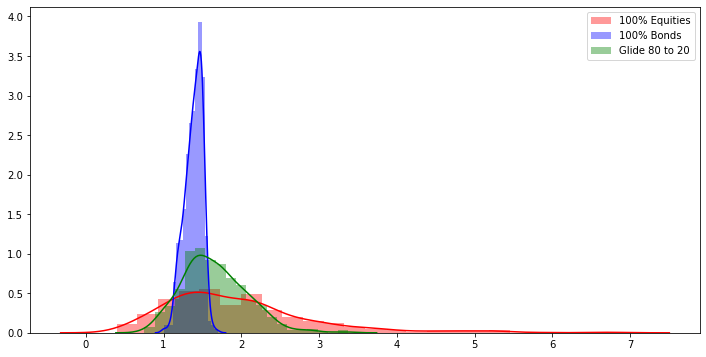

In [29]:
plt.figure(figsize=(12,6))
sns.distplot(erk.terminal_values(rets_eq), color='red', label='100% Equities')
sns.distplot(erk.terminal_values(rets_bonds), color='blue', label='100% Bonds')
sns.distplot(erk.terminal_values(rets_g8020), color='green', label='Glide 80 to 20')
plt.legend()